# Load packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import json
import numpy as np

In [2]:
import sys

sys.path.append("../../resource/DexiNed")
sys.path.append("../../src")

from model import DexiNed
from dataset import BIPEDv2, transforms

# Prepare

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch = 1
batch_size = 8
learning_rate = 1e-4
biped_dataset = BIPEDv2(
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/imgs/train/rgbr/real/",
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real/"
)

model = DexiNed()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(biped_dataset, batch_size=4)
logging = {
    'train_loss': []
}


print(device)

cuda


# Train

In [5]:
# model.train()
# model = model.to(device)
# for e in range(epoch):
#     epoche_loss = []
#     for x, y in loader:
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad()
#         output = model(x)[-1].squeeze()
#         loss = criterion(output, y)
#         loss.backward()
#         optimizer.step()
#         print("*", end="", flush=True)
#         epoche_loss.append(loss.detach().item())
    
#     logging['train_loss'].append(np.mean(epoche_loss))
#     print(f"\nIn epoch {e}, the average loss is {logging['train_loss'][-1]}")

# # save files
# model = model.to('cpu')
# torch.save(model.state_dict(), "./checkpoints/cpt_visibility.pth")
# print(f"Succeed saving mdoel parameters in ./checkpoints/cpt_visibility.pth.")
# with open("./checkpoints/cpt_visibility.json", "w") as f:
#     json.dump(logging, f)
# print(f"Succeed saving log in ./checkpoints/cpt_visibility.json")

# Result

In [4]:
model.load_state_dict(torch.load("./checkpoints/cpt_visibility.pth", weights_only=True))

<All keys matched successfully>

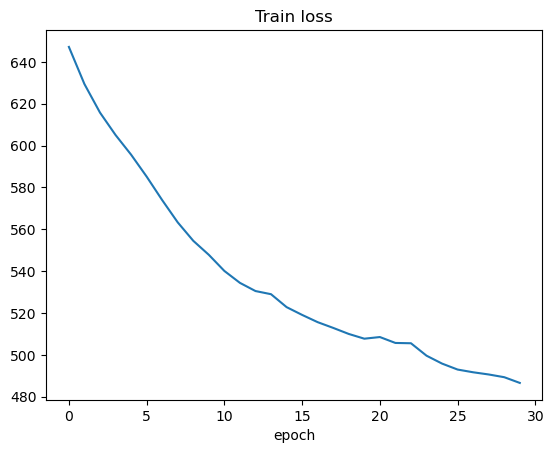

In [6]:
import json
import matplotlib.pyplot as plt

with open("./checkpoints/cpt_visibility.json", 'r') as f:
    logs = json.load(f)

plt.plot(logs['train_loss'])
plt.title("Train loss")
plt.xlabel("epoch")
plt.show()

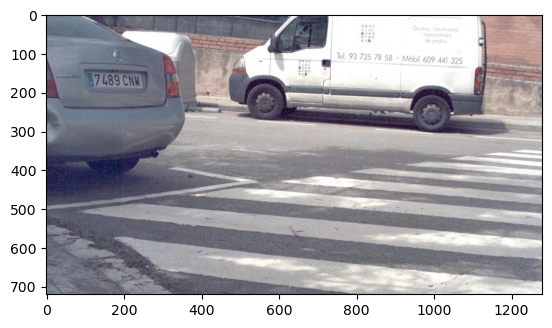

In [7]:
# take one example
x, y = biped_dataset[6]

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],  
    std=[1/s for s in std]
)


plt.imshow(denormalize(x).permute(1,2,0))
plt.show()

In [8]:
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

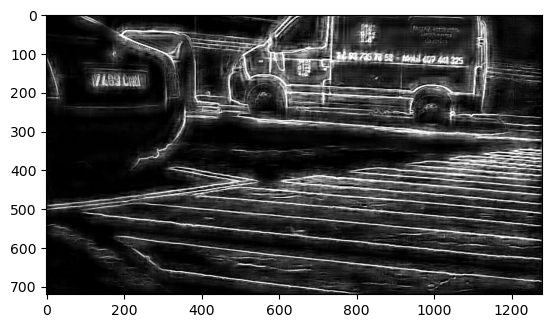

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def normalisation(img, percentile=95):
    res = img / np.percentile(img, percentile)
    res = np.where(res<0, 0, res)
    res = np.where(res>1, 1, res) 
    return res

plt.imshow(normalisation(yhat), cmap="gray")
plt.show()

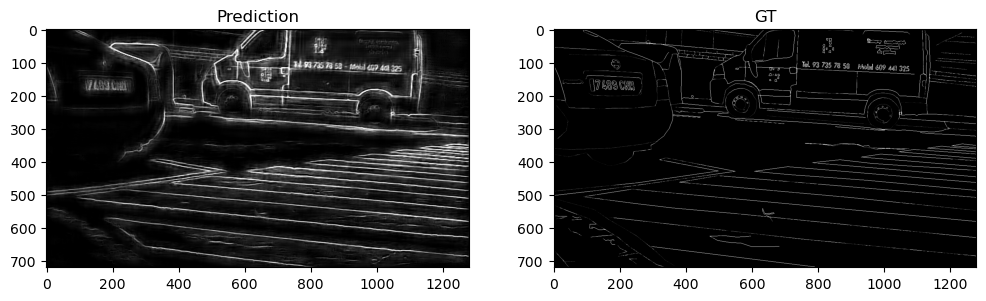

In [10]:
# display result
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
# fig.suptitle(img_index)
ax1.imshow(normalisation(yhat, 98), cmap="gray")
ax1.set_title("Prediction")
ax2.imshow(normalisation(y, 98), cmap="gray")
ax2.set_title("GT")
plt.show()